## A Fully Connected Neural Network for text classification

https://towardsdatascience.com/lstm-text-classification-using-pytorch-2c6c657f8fc0 

https://keras.io/examples/nlp/text_classification_with_transformer/ 

In [41]:
import pandas as pd
import numpy as np
import torch
import torchtext
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, confusion_matrix

In [2]:
train_data = pd.read_csv("../Datasets/data_train.csv")
val_data = pd.read_csv("../Datasets/data_val.csv")
test_data = pd.read_csv("../Datasets/data_test.csv")

## Using PyTorch

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/giacomomunda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/giacomomunda/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/giacomomunda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [30]:
class TextClassificationDataset(Dataset):
    def __init__(self, df, vectorizer, label_encoder):
        self.df = df
        self.vectorizer = vectorizer
        self.label_encoder = label_encoder
        self.stop_words = set(stopwords.words('english'))
        self.punctuation = set(string.punctuation)
        self.lemmatizer = WordNetLemmatizer()

    def preprocess_text(self, text):
        tokens = word_tokenize(text)
        tokens = [token.lower() for token in tokens if token not in self.stop_words and token not in self.punctuation]
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
        preprocess_text = " ".join(tokens)
        return preprocess_text
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        text = self.df.iloc[idx]["Text"]
        label = self.df.iloc[idx]["Emotion"]

        # Preprocess text
        text = self.preprocess_text(text)
        
        # Convert text to BOW vector
        bow = self.vectorizer.transform([text]).toarray()[0]
        
        # Convert label to numerical value
        label = self.label_encoder.transform([label])[0]
        
        return torch.LongTensor([label]), torch.FloatTensor(bow)
    

In [31]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(dropout_prob)
        self.fc2 = torch.nn.Linear(hidden_size, output_size)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.log_softmax(x)
        return x

In [32]:
# Load data from pandas dataframe
train_df = pd.read_csv("../Datasets/data_train.csv")
eval_df = pd.read_csv("../Datasets/data_val.csv")
test_df = pd.read_csv("../Datasets/data_test.csv")

# Create sorted list of unique labels
all_labels = np.concatenate([train_df["Emotion"].unique(), eval_df["Emotion"].unique()])
unique_labels = np.unique(all_labels)
sorted_labels = np.sort(unique_labels)

# Initialize vectorizer and label encoder
vectorizer = CountVectorizer()
label_encoder = LabelEncoder()

# Fit vectorizer and label encoder to training data
vectorizer.fit(train_df["Text"])
label_encoder.fit(train_df["Emotion"])

# Create dataset and data loader for training data
train_dataset = TextClassificationDataset(train_df, vectorizer, label_encoder)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Fit a new label encoder to the evaluation labels only
eval_labels = eval_df["Emotion"]
eval_label_encoder = LabelEncoder()
eval_label_encoder.fit(eval_labels)

# Create dataset and data loader for evaluation data
eval_dataset = TextClassificationDataset(eval_df, vectorizer, eval_label_encoder)
eval_dataloader = DataLoader(eval_dataset, batch_size=16, shuffle=True)

# Fit a new label encoder to the test labels only
test_labels = test_df["Emotion"]
test_label_encoder = LabelEncoder()
test_label_encoder.fit(test_labels)

# Create dataset and data loader for test data
test_dataset = TextClassificationDataset(test_df, vectorizer, test_label_encoder)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)


In [33]:
net = NeuralNetwork(len(vectorizer.vocabulary_), 20, 6, 0.2)

# define loss function and optimizer
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5)

best_val_accuracy = 0
best_model = None

# Initialize lists to store loss and accuracy values
train_losses, val_losses = [], []
val_accs, test_accs = [], []

# Early stopping parameters
patience = 3 # Number of epochs to wait before stopping
counter = 0 # Number of epochs with no improvement
best_loss = float('inf') # Best validation loss seen so far

# Train model
for epoch in range(8):
    total_loss, total_acc, count = 0, 0, 0
    net.train()
    for labels, features in train_dataloader:
        optimizer.zero_grad()
        out = net(features)
        labels = labels.squeeze(1)
        loss = loss_fn(out, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}: training loss = {total_loss/len(train_dataset)}")

    # Evaluate model on validation set
    net.eval()
    total_correct = 0
    val_loss = 0
    with torch.no_grad():
        for labels, features in eval_dataloader:
            out = net(features)
            labels = labels.squeeze(1)
            _, predicted = torch.max(out, dim=1)
            total_correct += (predicted == labels).sum().item()
            val_loss += loss_fn(out, labels).item()
        val_accuracy = total_correct / len(eval_dataset)
        val_loss /= len(eval_dataset)
        
    print(f"Accuracy: {val_accuracy}, Validation loss: {val_loss}")

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        best_val_accuracy = val_accuracy
        best_model = net.state_dict()
        torch.save(best_model, "best_model_with_regularization3.pt")
        counter = 0 # Reset counter since we have seen improvement
    else:
        counter += 1 # No improvement, increase counter
        if counter >= patience:
            print(f"No improvement after {patience} epochs. Stopping training.")
            break

    # Evaluate model on test set
    net.load_state_dict(best_model)
    net.eval()
    total_correct = 0
    with torch.no_grad():
        for labels, features in test_dataloader:
            out = net(features)
            labels = labels.squeeze(1)
            _, predicted = torch.max(out, dim=1)
            total_correct += (predicted == labels).sum().item()
        test_accuracy = total_correct / len(test_dataset)

    print(f"Test accuracy: {test_accuracy}")

    # Save loss and accuracy values
    train_losses.append(total_loss / len(train_dataset))
    val_losses.append(val_loss)
    val_accs.append(val_accuracy)
    test_accs.append(test_accuracy)


Epoch 0: training loss = 0.07615679498389107
Accuracy: 0.848424212106053, Validation loss: 0.04242834984033689
Test accuracy: 0.8544272136068034
Epoch 1: training loss = 0.02618028012696516
Accuracy: 0.8939469734867433, Validation loss: 0.02220205503472571
Test accuracy: 0.888944472236118
Epoch 2: training loss = 0.0133846907528503
Accuracy: 0.8959479739869936, Validation loss: 0.018859674055511325
Test accuracy: 0.8949474737368684
Epoch 3: training loss = 0.009180689014189858
Accuracy: 0.894447223611806, Validation loss: 0.018325064983545036
Test accuracy: 0.8949474737368684
Epoch 4: training loss = 0.006809096256558219
Accuracy: 0.8984492246123061, Validation loss: 0.018985294501645197
Test accuracy: 0.8939469734867433
Epoch 5: training loss = 0.005415792768221893
Accuracy: 0.9024512256128064, Validation loss: 0.019695045043988755
Test accuracy: 0.8954477238619309
Epoch 6: training loss = 0.0045277723825173834
Accuracy: 0.9014507253626813, Validation loss: 0.020791217663314654
No imp

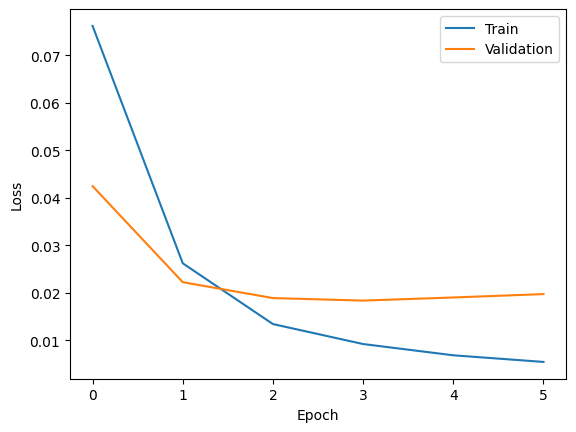

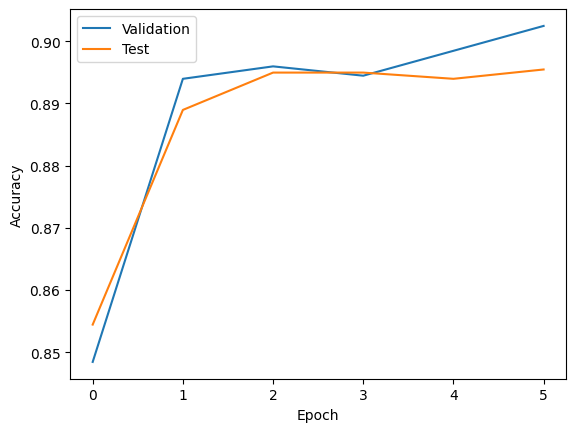

In [34]:
# Plot loss
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot accuracy
plt.plot(val_accs, label="Validation")
plt.plot(test_accs, label="Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Results:**

- *Fully Connected with CountVectorizer:*

    8 Epochs --> Accuracy: 0.8799 | Loss: 0.0017039 (best loss)

    Best validation accuracy score: 0.8909 (Epoch 3)

    After preprocessing --> best validation accuracy score:

                            Epoch 5: 0.8984


- *Fully Connected with TfidfVectorizer:*

    8 epochs --> Accuracy: 0.8799 | Loss: 0.0026595

    Best accuracy score: 0.8849

    After preprocessing --> best accuracy score: 0.8879 (Epoch 6)
                            
                            Epoch 8: 0.8854

- *Fully Connected with Regularization (L2 Norm and Dropout) and early stopping:*

    8 Epochs (but stopping at 6) --> Accuracy: 0.9024 | Training Loss: 0.0054157 | Val Loss: 0.019695

    Best validation accuracy score: 
                        
                            Epoch 6: 0.9024

    Best models so far: "best_model_with_regularization2", "best_model_with_regularization3"

**Doing inference with the trained model**

In [38]:
loaded_state_dict = torch.load("best_model_with_regularization3.pt")
net.load_state_dict(loaded_state_dict)

# prepare input data for inference
new_data = ["Today I went to the supermarket and bought some fruits, they were delicious!", 
            "I hate this movie", 
            "I was very pleased to see my daughter today",
            "Why are you so angry?",
            "Studying computational linguistics can be hard, but very satisfying!",
            "What are you doing for Christmas? I hope you have a great time"]

# convert input data to BOW vectors
new_data_bow = vectorizer.transform(new_data).toarray()

# run model on input data
net.eval()
with torch.no_grad():
    output_tensor = net(torch.FloatTensor(new_data_bow))
    _, predicted = torch.max(output_tensor, dim=1)
    predicted_labels = label_encoder.inverse_transform(predicted)
    for i, sentence in enumerate(new_data):
        print(f"'{sentence}' | Predicted emotion: {predicted_labels[i]}\n")

'Today I went to the supermarket and bought some fruits, they were delicious!' | Predicted emotion: joy

'I hate this movie' | Predicted emotion: joy

'I was very pleased to see my daughter today' | Predicted emotion: joy

'Why are you so angry?' | Predicted emotion: anger

'Studying computational linguistics can be hard, but very satisfying!' | Predicted emotion: joy

'What are you doing for Christmas? I hope you have a great time' | Predicted emotion: sadness



**Computing the F1-Score on the test data**

In [40]:
# Compute F1-score on test data
net.eval()
total_correct = 0
true_labels, predicted_labels = [], []
with torch.no_grad():
    for labels, features in test_dataloader:
        out = net(features)
        labels = labels.squeeze(1)
        _, predicted = torch.max(out, dim=1)
        total_correct += (predicted == labels).sum().item()
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())
    test_accuracy = total_correct / len(test_dataset)
    test_f1_score = f1_score(true_labels, predicted_labels, average='weighted')
    
print(f"Test accuracy: {test_accuracy}, Test F1-score: {test_f1_score}")

Test accuracy: 0.8949474737368684, Test F1-score: 0.8939361266277999


**Confusion Matrix**

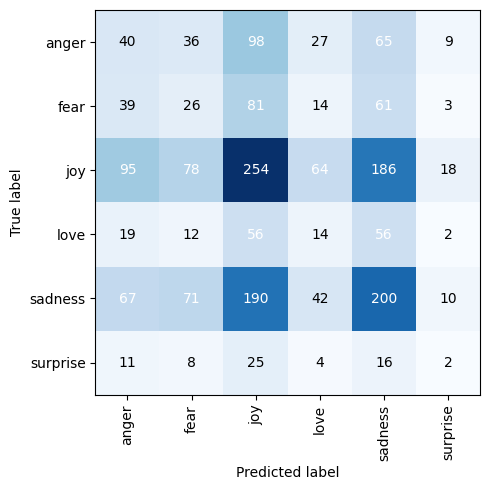

In [42]:
# Put the model in evaluation mode
net.eval()

# Classify the test data and compute the predicted labels
y_true = test_data["Emotion"].tolist()
y_pred = []
with torch.no_grad():
    for labels, features in test_dataloader:
        out = net(features)
        _, predicted = torch.max(out, dim=1)
        y_pred.extend(predicted.tolist())
y_pred = label_encoder.inverse_transform(y_pred)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=label_encoder.classes_.tolist())

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(cm, cmap='Blues')

# Set the tick labels
ax.set_xticks(np.arange(len(label_encoder.classes_)))
ax.set_yticks(np.arange(len(label_encoder.classes_)))
ax.set_xticklabels(label_encoder.classes_, rotation=90)
ax.set_yticklabels(label_encoder.classes_)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")

# Add annotations to the plot
for i in range(len(label_encoder.classes_)):
    for j in range(len(label_encoder.classes_)):
        text = ax.text(j, i, cm[i, j], ha="center", va="center", color="white" if cm[i, j] > len(y_true)/len(label_encoder.classes_)**2 else "black")

# Show the plot
plt.show()